## Partie modélisation

In [1]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyRegressor
from sklearn.metrics import root_mean_squared_error, make_scorer
from sklearn.feature_selection import r_regression
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder, OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../4072eb5e-e963-4a17-a794-3ea028d0a9c4.csv")
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True)

In [3]:
# Définir les tranches de BMI
# bins = [0, 18.5, 24.9, 29.9, 40, 100]  # Tranches de BMI
# labels = ['Sous-poids', 'Poids normal', 'Surpoids', 'Obésité', 'Obésité sévère']
bins = [0, 29.9, 100]  # Tranches de BMI
labels = ['Poids normal', 'Obésité']

# Ajouter une nouvelle colonne dans le DataFrame pour les tranches de BMI
df["BMI_category"] = pd.cut(df['bmi'], bins=bins, labels=labels, right=False)

In [4]:
del df["index"]
df.head()

,age,sex,bmi,children,smoker,region,charges,BMI_category
0,19,female,27.900,0,yes,southwest,16884.92400,Poids normal
1,18,male,33.770,1,no,southeast,1725.55230,Obésité
2,28,male,33.000,3,no,southeast,4449.46200,Obésité
3,33,male,22.705,0,no,northwest,21984.47061,Poids normal
4,32,male,28.880,0,no,northwest,3866.85520,Poids normal


In [5]:
features_of_interest = [
    "age",
    "sex",
    "children",
    "smoker",
    "region",
    "bmi",
    "BMI_category"
]

numerical_column = [
    "age",
    "children",
    "bmi"
]

ordinal_column = [
    "sex",
    "smoker",
    "BMI_category"
]

categorical_column = [
    "region",
]


target_name = "charges"
data, target, numerical_data, ordinal_data, categorical_data = (
    df[features_of_interest],
    df[target_name],
    df[numerical_column],
    df[ordinal_column],
    df[categorical_column]
)

### Training set

On prend un training set en faisant attention à la proportion de fumeur qui est importante :

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data, target, shuffle=True, train_size=0.85, random_state=42, stratify=data['smoker'])

### dummy model

In [7]:
dummy_model = DummyRegressor()
_ = dummy_model.fit(X_train,y_train)

In [8]:
target_predicted = dummy_model.predict(X_test)
target_predicted

array([13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
      

On obtient bien un modèle qui nous prédit pour tout le monde la moyenne des charges...

In [9]:
rmse = root_mean_squared_error(dummy_model.predict(X_test), y_test)
rmse

12054.89618229247

Avec un rmse de 12105 ce qui est beaucoup

### première regression linéaire

Les r2 pour nos valeurs numériques :

In [10]:
r_regression(numerical_data, target)

array([0.29830821, 0.06738935, 0.19840083])

In [11]:
preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(), categorical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column),
    ("numeric", StandardScaler(), numerical_column)
    ],
    remainder="passthrough",
)

linear_model = make_pipeline(preprocessor, LinearRegression())
linear_model.fit(X_train,y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(), ['region']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['sex', 'smoker',
                                                   'BMI_category']),
                                                 ('numeric', StandardScaler(),
                                                  ['age', 'children',
                                                   'bmi'])])),
                ('linearregression', LinearRegression())])

In [12]:
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

In [13]:
cv_results = cross_validate(
    linear_model,
    data,
    target,
    cv=10,
    scoring={"r2": "r2", "rmse":rmse_scorer},
    return_train_score=True,
    return_estimator=True,
)

In [14]:
cv_results["test_r2"].mean()

np.float64(0.7483940968633271)

In [15]:
cv_results["test_rmse"].mean()

np.float64(-6017.0421240114865)

On obtient en moyenne un rmse d'environ 6000 ce qui est toujours mieux que le dummy model mais pas tant...

### avec polynomiale features

In [16]:
preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(), categorical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column),
    ("numeric", StandardScaler(), numerical_column)
    ],
    remainder="passthrough",
)

linear_model = make_pipeline(preprocessor, PolynomialFeatures(2), LinearRegression())
linear_model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(), ['region']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['sex', 'smoker',
                                                   'BMI_category']),
                                                 ('numeric', StandardScaler(),
                                                  ['age', 'children',
                                                   'bmi'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [17]:
root_mean_squared_error(linear_model.predict(X_test), y_test)

3507.6595425525206

In [18]:
linear_model.score(X_test,y_test)

0.9150977572496746

On obtient un meilleur score. Etudions le poid de nos nouvelles features :

In [ ]:
pd.set_option("display.max_columns", 100)
pd.DataFrame(data = [linear_model[-1].coef_ ], columns=linear_model[:2].get_feature_names_out())


,1,categorical__region_northeast,categorical__region_northwest,categorical__region_southeast,categorical__region_southwest,ordinal__sex,ordinal__smoker,ordinal__BMI_category,numeric__age,numeric__children,numeric__bmi,categorical__region_northeast^2,categorical__region_northeast categorical__region_northwest,categorical__region_northeast categorical__region_southeast,categorical__region_northeast categorical__region_southwest,categorical__region_northeast ordinal__sex,categorical__region_northeast ordinal__smoker,categorical__region_northeast ordinal__BMI_category,categorical__region_northeast numeric__age,categorical__region_northeast numeric__children,categorical__region_northeast numeric__bmi,categorical__region_northwest^2,categorical__region_northwest categorical__region_southeast,categorical__region_northwest categorical__region_southwest,categorical__region_northwest ordinal__sex,categorical__region_northwest ordinal__smoker,categorical__region_northwest ordinal__BMI_category,categorical__region_northwest numeric__age,categorical__region_northwest numeric__children,categorical__region_northwest numeric__bmi,categorical__region_southeast^2,categorical__region_southeast categorical__region_southwest,categorical__region_southeast ordinal__sex,categorical__region_southeast ordinal__smoker,categorical__region_southeast ordinal__BMI_category,categorical__region_southeast numeric__age,categorical__region_southeast numeric__children,categorical__region_southeast numeric__bmi,categorical__region_southwest^2,categorical__region_southwest ordinal__sex,categorical__region_southwest ordinal__smoker,categorical__region_southwest ordinal__BMI_category,categorical__region_southwest numeric__age,categorical__region_southwest numeric__children,categorical__region_southwest numeric__bmi,ordinal__sex^2,ordinal__sex ordinal__smoker,ordinal__sex ordinal__BMI_category,ordinal__sex numeric__age,ordinal__sex numeric__children,ordinal__sex numeric__bmi,ordinal__smoker^2,ordinal__smoker ordinal__BMI_category,ordinal__smoker numeric__age,ordinal__smoker numeric__children,ordinal__smoker numeric__bmi,ordinal__BMI_category^2,ordinal__BMI_category numeric__age,ordinal__BMI_category numeric__children,ordinal__BMI_category numeric__bmi,numeric__age^2,numeric__age numeric__children,numeric__age numeric__bmi,numeric__children^2,numeric__children numeric__bmi,numeric__bmi^2
0,-6.239908e-13,368.240006,62.866304,167.34466,-598.450971,-296.350562,13632.813469,1.546987,2737.214993,775.395747,381.6192,368.240006,4.092726e-12,2.273737e-13,-2.046363e-12,-531.590686,2865.285548,977.858414,316.939043,395.60294,995.430916,62.866304,9.094947e-13,-4.774847e-12,323.511462,4098.677384,-732.109582,559.924607,518.639925,-318.3339,167.34466,-2.273737e-12,5.184246,3239.769255,-1186.628415,1064.318195,-100.662959,-642.634809,-598.450971,-93.455584,3429.081282,942.426571,796.033147,-38.184159,347.156994,-296.350562,-294.858654,305.812598,130.734254,1.136504,201.629346,13632.813469,-14326.746342,-351.410322,-421.455271,3436.777088,1.546987,322.031697,343.865877,-781.656504,817.319493,-30.369147,113.453928,-166.954049,187.780564,-238.074762


In [20]:
weights = linear_model[-1].coef_ 
null_features_weight = [w for w in weights if abs(w) < 0.001]
len(null_features_weight)

7

On a 7 des features dont on peut se débarasser. Utilisons maintenant Lasso.

### avec lasso

In [21]:
preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(), categorical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column),
    ("numeric", StandardScaler(), numerical_column)
    ],
    remainder="passthrough",
)

lasso_model = make_pipeline(preprocessor, PolynomialFeatures(2), Lasso(1))
lasso_model.fit(X_train,y_train)

/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.061e+08, tolerance: 1.667e+07
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(), ['region']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['sex', 'smoker',
                                                   'BMI_category']),
                                                 ('numeric', StandardScaler(),
                                                  ['age', 'children',
                                                   'bmi'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('lasso', Lasso(alpha=1))])

In [22]:
lasso_model.score(X_test,y_test)

0.9151256397794052

In [23]:
root_mean_squared_error(lasso_model.predict(X_test), y_test)

3507.083524479312

Pas de gain significatif. Faison une étude Pour trouver les meilleurs hyper paramètres : 

### Hyperparamètre tuning Lasso

In [24]:
lasso_model = Pipeline([
    ("preprocessor", preprocessor),
    ("poly", PolynomialFeatures()),
    ("lasso", Lasso())
])

param_grid = {
    "poly__degree": [2, 3], 
    "lasso__alpha": np.linspace(1, 40000, 50), 
}

grid_search = GridSearchCV(
    lasso_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X_train, y_train)

grid_search.best_params_

/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.057e+08, tolerance: 1.315e+07
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.072e+08, tolerance: 1.298e+07
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarn

{'lasso__alpha': np.float64(1.0), 'poly__degree': 2}

In [25]:
grid_search.best_score_

np.float64(0.8492190115077864)

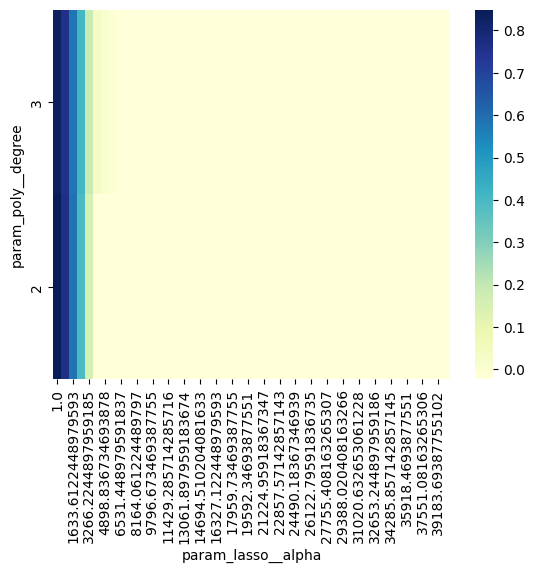

In [26]:
cv_results = pd.DataFrame(grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
)
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += ["mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score",
    index=["param_poly__degree"],
    columns=["param_lasso__alpha"],
    )

import seaborn as sns

ax = sns.heatmap(
    pivoted_cv_results, cmap="YlGnBu"
)
ax.invert_yaxis()

on peut abandoner le degre 3 et on va se concentrer sur des valeurs de alpha entre 0 et 1000...

In [27]:
param_grid = {
    "lasso__alpha": np.linspace(1, 1000, 1000), 
}

grid_search = GridSearchCV(
    lasso_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X_train, y_train)

grid_search.best_params_

/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.057e+08, tolerance: 1.315e+07
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.072e+08, tolerance: 1.298e+07
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarn

{'lasso__alpha': np.float64(26.0)}

In [28]:
grid_search.best_score_

np.float64(0.851336707360808)

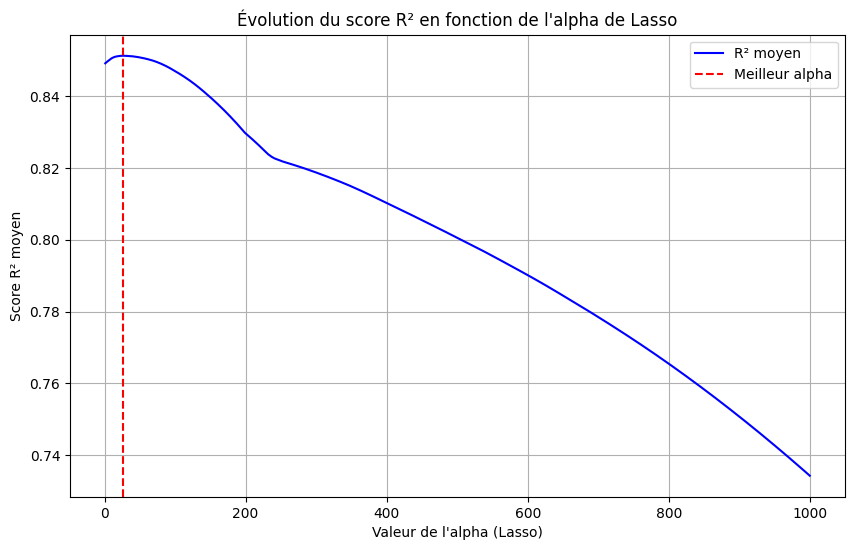

In [29]:
results = grid_search.cv_results_
alphas = results["param_lasso__alpha"].data
mean_scores = results["mean_test_score"]  


plt.figure(figsize=(10, 6))
plt.plot(alphas, mean_scores, label="R² moyen", color="blue")

# Ajouter des annotations
plt.axvline(grid_search.best_params_["lasso__alpha"], color="red", linestyle="--", label="Meilleur alpha")
plt.xlabel("Valeur de l'alpha (Lasso)")
plt.ylabel("Score R² moyen")
plt.title("Évolution du score R² en fonction de l'alpha de Lasso")
plt.legend()
plt.grid(True)
plt.show()

Le meilleur alpha semble être 45. Essayons tout de même entre 0 et 1 :

In [30]:
param_grid = {
    "lasso__alpha": np.linspace(0, 1, 101), 
}

grid_search = GridSearchCV(
    lasso_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X_train, y_train)

grid_search.best_params_

/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.482e+09, tolerance: 1.315e+07 Linear regression models wit

{'lasso__alpha': np.float64(1.0)}

In [31]:
grid_search.best_score_

np.float64(0.8492190115077864)

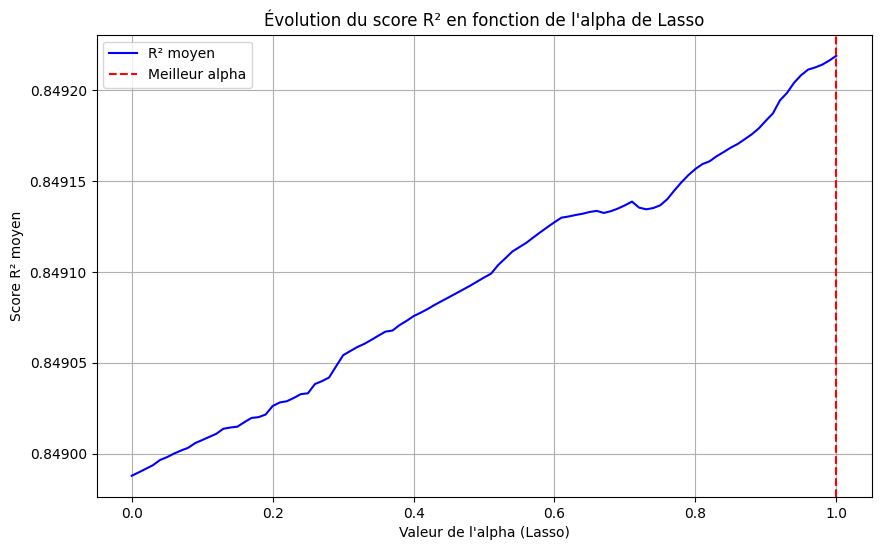

In [32]:
results = grid_search.cv_results_
alphas = results["param_lasso__alpha"].data
mean_scores = results["mean_test_score"]  


plt.figure(figsize=(10, 6))
plt.plot(alphas, mean_scores, label="R² moyen", color="blue")

# Ajouter des annotations
plt.axvline(grid_search.best_params_["lasso__alpha"], color="red", linestyle="--", label="Meilleur alpha")
plt.xlabel("Valeur de l'alpha (Lasso)")
plt.ylabel("Score R² moyen")
plt.title("Évolution du score R² en fonction de l'alpha de Lasso")
plt.legend()
plt.grid(True)
plt.show()

45 et meilleur. Etudions maintenant les carrés du polynôme avec un alpha pour alpha entre 35 et 55 :

In [33]:
param_grid = {
    "poly__interaction_only": [True, False], 
    "lasso__alpha": np.linspace(35, 55, 21), 
}

grid_search = GridSearchCV(
    lasso_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'lasso__alpha': np.float64(35.0), 'poly__interaction_only': False}

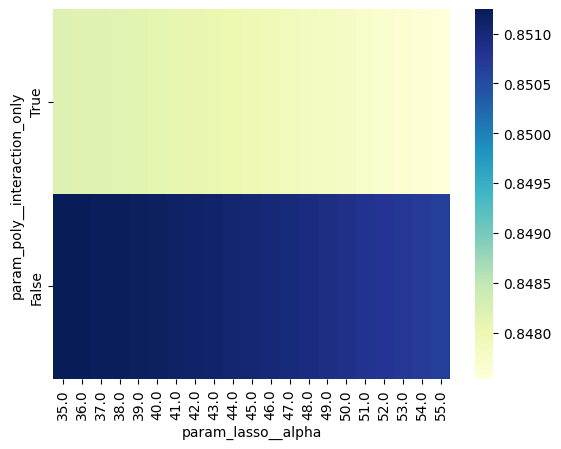

In [34]:
cv_results = pd.DataFrame(grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
)
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += ["mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score",
    index=["param_poly__interaction_only"],
    columns=["param_lasso__alpha"],
    )

import seaborn as sns

ax = sns.heatmap(
    pivoted_cv_results, cmap="YlGnBu"
)
ax.invert_yaxis()

On a de meilleurs résultats en conservant les carrés...

In [35]:
lasso_model.set_params(poly__degree=2, lasso__alpha=45)
lasso_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(), ['region']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['sex', 'smoker',
                                                   'BMI_category']),
                                                 ('numeric', StandardScaler(),
                                                  ['age', 'children',
                                                   'bmi'])])),
                ('poly', PolynomialFeatures()), ('lasso', Lasso(alpha=45))])

In [36]:
lasso_model.score(X_test,y_test)

0.917057136200423

L'amélioration est tout de même peu significative...

In [37]:
root_mean_squared_error(lasso_model.predict(X_test), y_test)

3466.9483008179636

In [38]:
lasso_model.set_params(poly__degree=2, lasso__alpha=45)
lasso_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(), ['region']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['sex', 'smoker',
                                                   'BMI_category']),
                                                 ('numeric', StandardScaler(),
                                                  ['age', 'children',
                                                   'bmi'])])),
                ('poly', PolynomialFeatures()), ('lasso', Lasso(alpha=45))])

In [39]:
lasso_model.score(X_test,y_test)

0.917057136200423

In [40]:
root_mean_squared_error(lasso_model.predict(X_test), y_test)

3466.9483008179636

### Elastic net

In [ ]:
elastic_net_model = Pipeline([
    ("preprocessor", preprocessor),
    ("poly", PolynomialFeatures()),
    ("elastic", ElasticNet())
])
elastic_net_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(), ['region']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['sex', 'smoker',
                                                   'BMI_category']),
                                                 ('numeric', StandardScaler(),
                                                  ['age', 'children',
                                                   'bmi'])])),
                ('poly', PolynomialFeatures()), ('elastic', ElasticNet())])

In [42]:
ElasticNet().get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 1000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [43]:
elastic_net_model.score(X_test,y_test)

0.658059038682554

In [ ]:
root_mean_squared_error(elastic_net_model.predict(X_test), y_test)

7039.363897514544

In [45]:
param_grid = {
    "elastic__l1_ratio": np.linspace(0, 1, 20), 
    "elastic__alpha": np.linspace(1, 100, 20)
}

grid_search = GridSearchCV(
    elastic_net_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X_train, y_train)

/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.721e+10, tolerance: 1.315e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.756e+10, tolerance: 1.298e+07 Linear regression models wit

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(),
                                                                         ['region']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'BMI_category']),
                                                                        ('numeric',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'children',
                                                                          'bmi'])])),
                                       ('poly', PolynomialFeatures()),
                                       ('elastic', ElasticNet())]),
             param_grid={'ela...
        42.68421053,  47.89473684,  53.10526316,  58.31578947,
        63.52631579,  68.73684211,  73.94736842,  79.15789474,
        84.36842105,  89.57894737,  94.78947368, 100.        ]),
                         'elastic__l1_ratio': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])},
             scoring='r2')

In [46]:
print(grid_search.best_params_, grid_search.best_score_)

{'elastic__alpha': np.float64(27.052631578947366), 'elastic__l1_ratio': np.float64(1.0)} 0.8513316015310508


In [47]:
cv_results = pd.DataFrame(grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
)

In [48]:
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += ["mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [49]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score",
    index=["param_elastic__l1_ratio"],
    columns=["param_elastic__alpha"],
    )

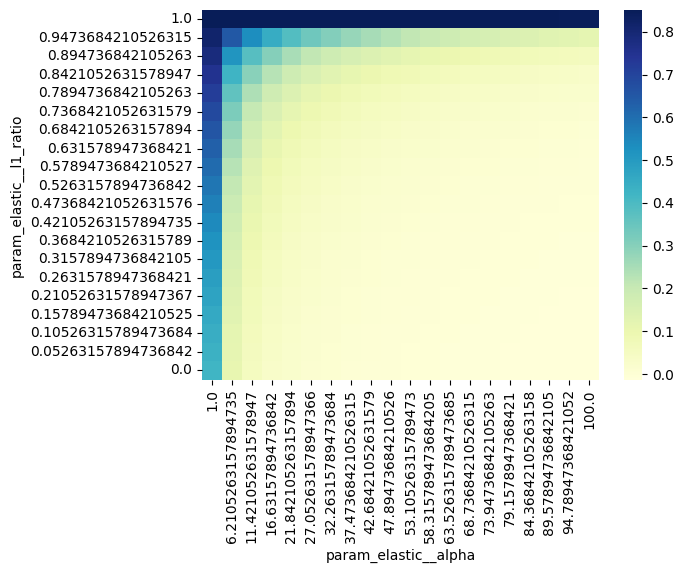

In [50]:
import seaborn as sns

ax = sns.heatmap(
    pivoted_cv_results, cmap="YlGnBu"
)
ax.invert_yaxis()

In [51]:
param_grid = {
    "elastic__l1_ratio": np.linspace(0.9, 1, 20), 
    "elastic__alpha": np.linspace(50, 150, 100)
}

grid_search = GridSearchCV(
    elastic_net_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(),
                                                                         ['region']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'BMI_category']),
                                                                        ('numeric',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'children',
                                                                          'bmi'])])),
                                       ('poly', PolynomialFeatures()),
                                       ('elastic', ElasticNet())]),
             param_grid={'ela...
       138.88888889, 139.8989899 , 140.90909091, 141.91919192,
       142.92929293, 143.93939394, 144.94949495, 145.95959596,
       146.96969697, 147.97979798, 148.98989899, 150.        ]),
                         'elastic__l1_ratio': array([0.9       , 0.90526316, 0.91052632, 0.91578947, 0.92105263,
       0.92631579, 0.93157895, 0.93684211, 0.94210526, 0.94736842,
       0.95263158, 0.95789474, 0.96315789, 0.96842105, 0.97368421,
       0.97894737, 0.98421053, 0.98947368, 0.99473684, 1.        ])},
             scoring='r2')

In [52]:
print(grid_search.best_params_, grid_search.best_score_)

{'elastic__alpha': np.float64(50.0), 'elastic__l1_ratio': np.float64(1.0)} 0.850859083684815


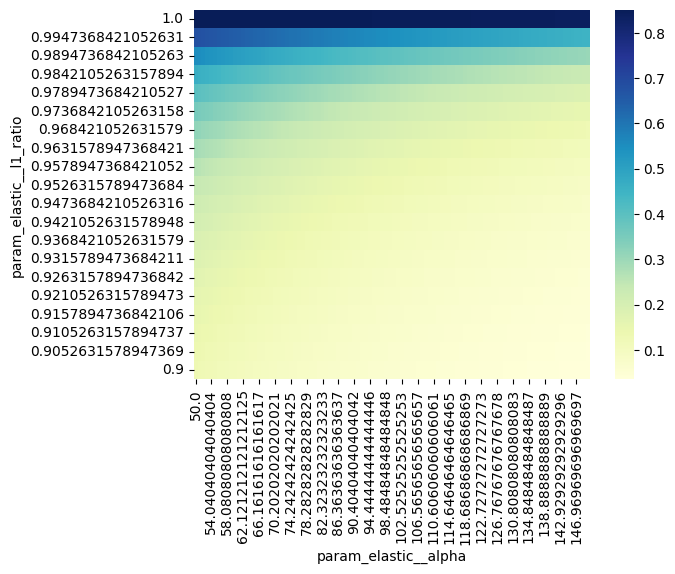

In [53]:
cv_results = pd.DataFrame(grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
)
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += ["mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score",
    index=["param_elastic__l1_ratio"],
    columns=["param_elastic__alpha"],
    )

import seaborn as sns

ax = sns.heatmap(
    pivoted_cv_results, cmap="YlGnBu"
)
ax.invert_yaxis()


## Analyse des résultats

On va d'abord récuperer nos données transformé.

In [54]:
data_transform = pd.DataFrame(data = lasso_model[:2].fit_transform(X_train), columns=lasso_model[:2].get_feature_names_out())

In [55]:
X = data_transform
Y = y_train.reset_index()

Je créer une data frame avec nos index pour receuillir les résultats

In [56]:
analyses = pd.DataFrame(Y["index"])
analyses

,index
0,1094
1,94
2,349
3,410
4,981
...,...
1131,674
1132,752
1133,319
1134,934


In [57]:
n,p = X.shape
print(n,p)

1136 66


Ensuite on implémente la régression linéaire avec statsmodels :

In [58]:
import statsmodels.api as sm
X = sm.add_constant(X) # J'ajoute une colonne de 1 qui va corespondre à l'intercept 
reg_multi = sm.OLS(Y.drop("index", axis=1),X) 
reg_multi = reg_multi.fit()


In [59]:
reg_multi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     151.5
Date:                Mon, 13 Jan 2025   Prob (F-statistic):               0.00
Time:                        14:06:59   Log-Likelihood:                -11167.
No. Observations:                1136   AIC:                         2.243e+04
Df Residuals:                    1090   BIC:                         2.266e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
1                                                            5405.4685    308.032     17.548      0.000    4801.065    6009.872
categorical__region_northeast                                1719.6071    261.679      6.571      0.000    1206.155    2233.059
categorical__region_northwest                                1414.2334    253.676      5.575      0.000     916.486    1911.981
categorical__region_southeast                                1518.7118    284.585      5.337      0.000     960.315    2077.108
categorical__region_southwest                                 752.9161    271.974      2.768      0.006     219.264    1286.568
ordinal__sex                                                 -296.3506    229.646     -1.290      0.197    -746.948     154.247
ordinal__smoker                                              1.363e+04    323.743     42.110      0.000     1.3e+04    1.43e+04
ordinal__BMI_category                                           1.5470    325.648      0.005      0.996    -637.421     640.515
numeric__age                                                 2737.2150    229.920     11.905      0.000    2286.078    3188.352
numeric__children                                             775.3957    251.141      3.087      0.002     282.621    1268.171
numeric__bmi                                                  381.6192    537.227      0.710      0.478    -672.496    1435.735
categorical__region_northeast^2                              1719.6071    261.679      6.571      0.000    1206.155    2233.059
categorical__region_northeast categorical__region_northwest  4.275e-12   6.31e-13      6.776      0.000    3.04e-12    5.51e-12
categorical__region_northeast categorical__region_southeast  1.091e-13   4.13e-13      0.264      0.792   -7.01e-13    9.19e-13
categorical__region_northeast categorical__region_southwest -3.016e-12   3.75e-13     -8.051      0.000   -3.75e-12   -2.28e-12
categorical__region_northeast ordinal__sex                   -531.5907    492.454     -1.079      0.281   -1497.855     434.674
categorical__region_northeast ordinal__smoker                2865.2855    621.028      4.614      0.000    1646.741    4083.831
categorical__region_northeast ordinal__BMI_category           977.8584    841.366      1.162      0.245    -673.022    2628.738
categorical__region_northeast numeric__age                    316.9390    250.843      1.263      0.207    -175.251     809.129
categorical__region_northeast numeric__children               395.6029    249.777      1.584      0.114     -94.495     885.701
categorical__region_northeast numeric__bmi                    995.4309    450.648      2.209      0.027     111.194    1879.667
categorical

### Etude d'atypicité

#### Sur les variable explicative

leviers des observations de Bersley : On peut calculer les leviers : $$h_{ii}=X_{i}^T(X^YX)^{-1}X_i$$ Si cette valeur est supérieur au seuil des leviers ($2∗\frac{p}{n}$) on peut considérer l'observation comme atypique.

In [60]:
analyses['levier'] = reg_multi.get_influence().hat_matrix_diag

seuil_levier = 2*p/n
print(seuil_levier)

0.11619718309859155


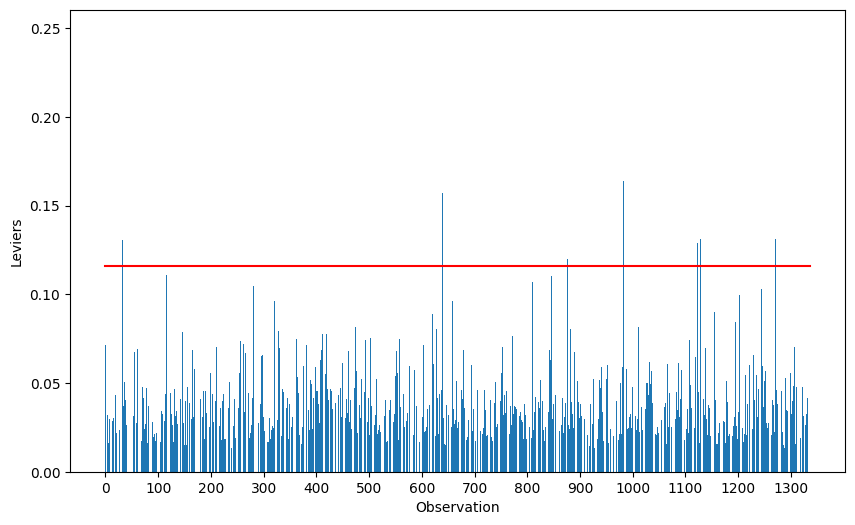

In [61]:
plt.figure(figsize=(10,6))
plt.bar(analyses['index'], analyses['levier'])
plt.xticks(np.arange(0, 1336, step=100))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1336], [seuil_levier, seuil_levier], color='r')
plt.show()

In [62]:
len(analyses.loc[analyses['levier'] > seuil_levier, :])

15

Nous n'avons que 16 valeurs atypiques sans considérer la target

#### Sur la variable à expliquer

In [63]:
alpha = 0.05

On calculs les résidus studentisés internes avec scipy et on fixe un alpha à 0.05 pour avoir une confiance de 95%

In [64]:
from scipy.stats import t
analyses['rstudent'] = reg_multi.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

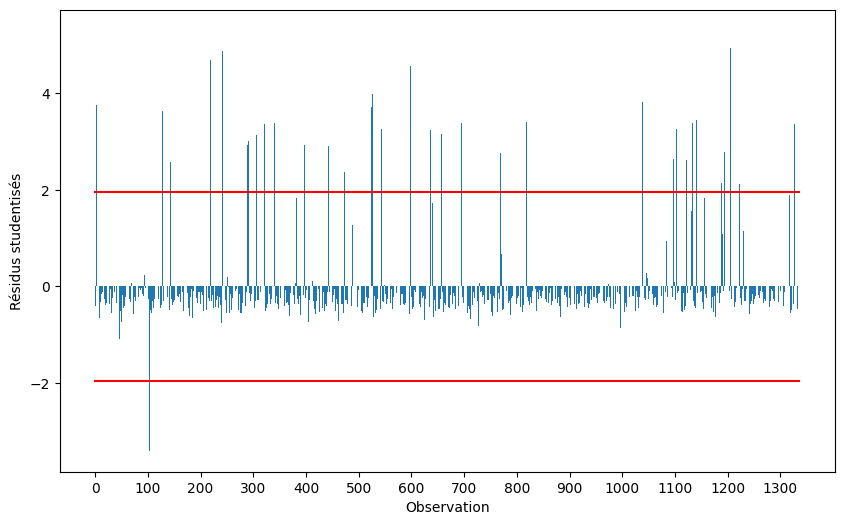

In [65]:
plt.figure(figsize=(10,6))
plt.bar(analyses['index'], analyses['rstudent'])
plt.xticks(np.arange(0, 1336, step=100))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, 1336], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 1336], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

In [66]:
len(analyses.loc[(analyses['rstudent'] > seuil_rstudent) | (analyses['rstudent'] < -seuil_rstudent) | (analyses['levier'] > seuil_levier),:])

95

In [67]:
df = pd.read_csv("../4072eb5e-e963-4a17-a794-3ea028d0a9c4.csv")

On a 95 valeurs atypiques en tout.

### Etude de l'influence :

On calcul pour charque observation la distance de COOK $D_i$ et on la considère influente si $$D_i > \dfrac{4}{n-p}$$

In [68]:
influence = reg_multi.get_influence().summary_frame()

In [69]:
analyses['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)

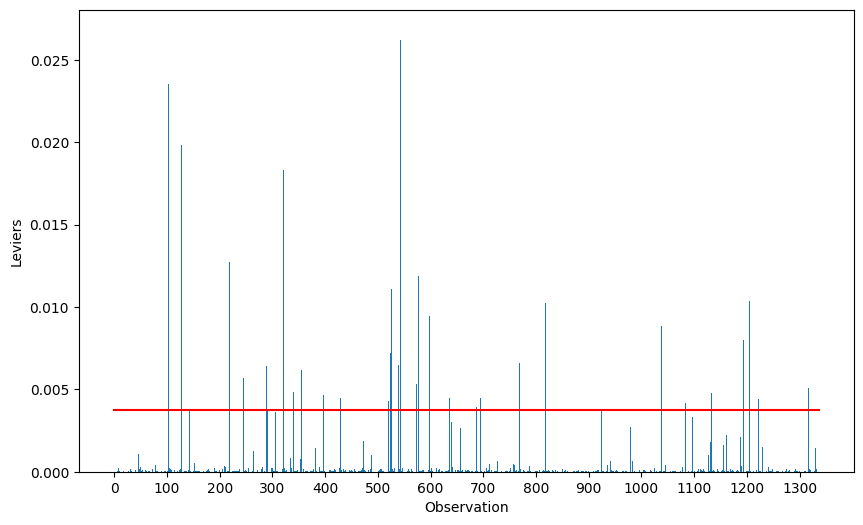

In [70]:
plt.figure(figsize=(10,6))
plt.bar(analyses['index'], analyses['dcooks'])
plt.xticks(np.arange(0, 1336, step=100))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1336], [seuil_dcook, seuil_dcook], color='r')
plt.show()

In [71]:
len(analyses.loc[analyses['dcooks'] > seuil_dcook, :])

60

On a 60 valeurs influentes. 

In [72]:
len(analyses.loc[(analyses['dcooks'] > seuil_dcook) & ((analyses['rstudent'] > seuil_rstudent) | (analyses['rstudent'] < -seuil_rstudent) | (analyses['levier'] > seuil_levier)),:])

59

Et 59 de ces valeurs sont atypiques.

### Tentative en enlevant les valeurs influentes et atypiques :

In [73]:
obesrvations_to_drop = analyses.loc[(analyses['dcooks'] > seuil_dcook) & ((analyses['rstudent'] > seuil_rstudent) | (analyses['rstudent'] < -seuil_rstudent) | (analyses['levier'] > seuil_levier)),:]

In [74]:
X_train

,age,sex,children,smoker,region,bmi,BMI_category
1094,18,female,4,no,northeast,31.350,Obésité
94,64,female,2,yes,southwest,31.300,Obésité
349,19,male,0,no,northwest,27.835,Poids normal
410,19,male,0,no,northwest,17.480,Poids normal
981,31,male,3,yes,southwest,25.900,Poids normal
...,...,...,...,...,...,...,...
674,45,male,0,no,northwest,21.375,Poids normal
752,58,female,0,no,southeast,22.770,Poids normal
319,32,male,1,no,northeast,37.335,Obésité
934,59,female,0,no,southwest,27.500,Poids normal


In [75]:
X2_train = X_train
y2_train = y_train
for index in obesrvations_to_drop["index"]:
    X2_train = X2_train.drop(index)
    y2_train = y2_train.drop(index)

In [76]:
lasso_model.fit(X_train,y_train)
lasso_model.score(X_test,y_test)

0.917057136200423

In [77]:
lasso_model.fit(X2_train,y2_train)
lasso_model.score(X_test,y_test)

0.9220276058902372

On a un meilleur modèle !

In [78]:
best_lasso_model = lasso_model.fit(X2_train,y2_train)

In [79]:
import pickle

with open('best_lasso_model.pkl', 'wb') as f:
    pickle.dump(best_lasso_model, f)